In [1]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
import skimage as ski
from matplotlib import animation            # Module to plot animations
from skimage.filters import difference_of_gaussians
from skimage import io, measure               # Module from skimage

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as ski_io
from cellpose import models
import pandas as pd

# Load the image
figName = './Drug2_1000nM/rep1_FOV1.tif'
img = ski_io.imread(figName)

# Initialize Cellpose models
model_cyto = models.Cellpose(gpu=False, model_type='cyto')
model_nuclei = models.Cellpose(gpu=False, model_type='nuclei')

# Create an empty DataFrame to store results
df_merged_all_frames = pd.DataFrame(columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes'])

# Iterate over frames
for selected_frame in range(len(img)):
    # Select the appropriate frame and color channel
    img_to_analyze = img[selected_frame, :, :, 1]  # Assuming channel 1 for cytoplasm detection

    # Run Cellpose for cytoplasm detection
    masks_cyto, _, _, _ = model_cyto.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        mask_initial_cyto = masks_cyto

    masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
    
    # Prepare data for the cytoplasm DataFrame
    data_cyto = []
    for cell_id in np.unique(masks_cyto):
        mask = masks_cyto == cell_id
        sum_pix_intensity = img_to_analyze[mask].sum()
        cell_sizes = np.sum(mask)

        data_cyto.append([selected_frame, cell_id, sum_pix_intensity, cell_sizes])

    df_cyto = pd.DataFrame(data_cyto, columns=['time', 'cell_ID', 'sum_pix_intensity_cyto', 'cell sizes'])

    img_to_analyze = img[selected_frame, :, :, 0]  # Assuming channel 1 for cytoplasm detection

    # Run Cellpose for nuclei detection
    masks_nuclei, _, _, _ = model_nuclei.eval(img_to_analyze, diameter=None, channels=[0, 0])

    if selected_frame == 0:
        # Save the initial nuclei mask to use it for the next frames
        # Compare the initial nuclei mask with the mask_initial_cyto to have the same IDs for the same cells
        masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_cyto) / masks_nuclei, 0)
        mask_initial_nuclei = masks_nuclei
        

    masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)

    # Prepare data for the nuclei DataFrame
    data_nuclei = []
    for cell_id in np.unique(masks_nuclei):
        mask = masks_nuclei == cell_id
        nucleus_sizes = np.sum(mask)
        sum_pix_intensity = img_to_analyze[mask].sum()

        data_nuclei.append([selected_frame, cell_id, nucleus_sizes, sum_pix_intensity])

    df_nuclei = pd.DataFrame(data_nuclei, columns=['time', 'cell_ID', 'nucleus sizes', 'sum_pix_intensity_nuclei'])

    # Merge the Cytoplasm and Nuclei DataFrames based on the 'cell' column
    df_merged = pd.merge(df_cyto, df_nuclei, on='cell_ID')
    df_merged['time'] = df_merged['time_x']
    df_merged = df_merged.drop(columns=['time_x', 'time_y'])
    df_merged = df_merged[['time', 'cell_ID', 'sum_pix_intensity_cyto', 'sum_pix_intensity_nuclei', 'cell sizes', 'nucleus sizes']]
    df_merged['protein concentrations (AU)'] = (df_merged['sum_pix_intensity_cyto'] - df_merged['sum_pix_intensity_nuclei']) / (df_merged['cell sizes'] - df_merged['nucleus sizes'])

    # Concatenate DataFrames instead of using append
    frames = [df_merged_all_frames, df_merged]
    df_merged_all_frames = pd.concat(frames, ignore_index=True)
    df_merged_all_frames = df_merged_all_frames[df_merged_all_frames['cell_ID'] != 0]

# Display the merged DataFrame for all frames
print("Merged DataFrame for all frames:")
print(df_merged_all_frames)

C:\Users\daria\AppData\Local\Temp\ipykernel_13824\2293788300.py:29: RuntimeWarning: invalid value encountered in divide
  masks_cyto = np.where(masks_cyto != 0, (masks_cyto * mask_initial_cyto) / masks_cyto, 0)
C:\Users\daria\AppData\Local\Temp\ipykernel_13824\2293788300.py:50: RuntimeWarning: invalid value encountered in divide
  masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_cyto) / masks_nuclei, 0)
C:\Users\daria\AppData\Local\Temp\ipykernel_13824\2293788300.py:54: RuntimeWarning: invalid value encountered in divide
  masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)
C:\Users\daria\AppData\Local\Temp\ipykernel_13824\2293788300.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the conca

Merged DataFrame for all frames:
    time  cell_ID sum_pix_intensity_cyto sum_pix_intensity_nuclei cell sizes  \
0      0      1.0                1115782                   418168       8364   
1      0      2.0                 483785                   389275       7429   
2      0      3.0                 998611                   475839       7841   
3      0      4.0                 610883                   407425       7054   
4      0      5.0                 691100                   408913       7096   
..   ...      ...                    ...                      ...        ...   
151   20      4.0                 481681                   408831       6999   
152   20      5.0                 572560                   407164       7014   
153   20      6.0                 505642                   442109       7770   
154   20      8.0                 484393                   421577       6815   
155   20      9.0                 566667                   419108       7218   

    nu

C:\Users\daria\AppData\Local\Temp\ipykernel_13824\2293788300.py:54: RuntimeWarning: invalid value encountered in divide
  masks_nuclei = np.where(masks_nuclei != 0, (masks_nuclei * mask_initial_nuclei) / masks_nuclei, 0)


In [8]:
initia

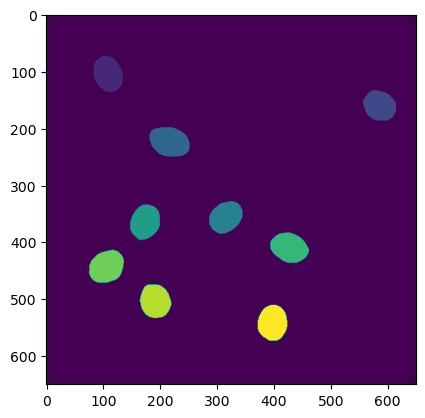

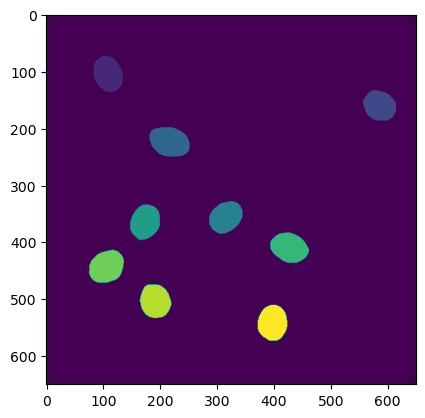

In [6]:
# Plotting the masked cytoplasm image
plt.imshow(mask_initial)
plt.show()
plt.imshow(masks_cyto)
plt.show()